# Sun_glint_correction

__What does this notebook do?__ This notebook corrects for sun glints over deep ocean using the Hedley (2005) correction method. There are a number of calculations included, so that your correction can be evaluated graphically for the area of interest. The notebook is divided into the following sections:
1. Load data for your area of interest ???what to do with areas with atolls!? add a nice thing to select an area
2. Identify glinted pixels in the area
3. Correct for glint
4. Plot reflectance values for different pixels for a visual check of if the correction is working
5. Load true-colour images to show glint correction
6. Export geotiffs of uncorrected and corrected data

__Date:__ April 2018

__Author:__ Snowy Haiblen (written during a graduate rotation, feel free to contact me for furter info (Anna.Haiblen@ga.gov.au))

## Load modules

In [2]:
# Import modules
import datacube
import numpy as np
import matplotlib.pyplot as plt
import pandas
import xarray as xr
import itertools
import matplotlib.patches as mpatches

from matplotlib.pyplot import imshow
from skimage import exposure
from datacube.storage import masking
from sklearn.linear_model import LinearRegression

# Import DEA Notebooks scripts


# Set up datacube instance
dc = datacube.Datacube(app='load-data-example')

## User inputs: area of interest, product, and time range

In [3]:
# Enter details of the imagery that you are interested in here. 

# Area of interest:
lat_min = -23.42 #up
lat_max = -23.52 #down
lon_min = 152.00 #left
lon_max = 152.10 #right

# Product (eg. 'ls8_nbar_albers'), and related pixel quality (pq) product (eg. 'ls8_pq_albers')
product = 'ls8_nbar_albers'
pq_product = 'ls8_pq_albers'

# Time range of interest ('yyyy-mm-dd')
start = '2015-01-01'
end = '2016-01-01'

# Image to correct for glint within specified time range (numbered by date order, first image = 0)
# image = 3

# Specify the minimum fraction of the image that is covered in cloud that you would like to see...
cloud_free_fraction = 0.95

## Load bands and correct for no data pixels and image overlap, and remove clouded imagery -  using ???the function saved elswhere???

In [4]:
# Claire's code

# Load the imagery for the area of interest from the datacube and name it 'dataset'

# Load modules
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
import gdal
import numpy as np
import xarray as xr
import rasterio

def load_nbarx(dc, sensor, query, product='nbart', bands_of_interest='', filter_pq=True):
    """
    Loads NBAR (Nadir BRDF Adjusted Reflectance) or NBAR-T (terrain corrected NBAR) data for a
    sensor, masks using pixel quality (PQ), then optionally filters out terrain -999s (for NBAR-T).
    Returns an xarray dataset and CRS and Affine objects defining map projection and geotransform
    Last modified: March 2018
    Author: Bex Dunn
    Modified by: Claire Krause, Robbi Bishop-Taylor
    inputs
    dc - Handle for the Datacube to import from. This allows you to also use dev environments
    if that have been imported into the environment.
    sensor - Options are 'ls5', 'ls7', 'ls8'
    query - A dict containing the query bounds. Can include lat/lon, time etc
    optional
    product - 'nbar' or 'nbart'. Defaults to nbart unless otherwise specified
    bands_of_interest - List of strings containing the bands to be read in; defaults to all bands,
                        options include 'red', 'green', 'blue', 'nir', 'swir1', 'swir2'
    filter_pq - boolean. Will filter clouds and saturated pixels using PQ unless set to False
    outputs
    ds - Extracted and optionally PQ filtered dataset
    crs - CRS object defining dataset coordinate reference system
    affine - Affine object defining dataset affine transformation
    """

    product_name = '{}_{}_albers'.format(sensor, product)
    mask_product = '{}_{}_albers'.format(sensor, 'pq')
    print('Loading {}'.format(product_name))

    # If bands of interest are given, assign measurements in dc.load call
    if bands_of_interest:

        ds = dc.load(product=product_name, measurements=bands_of_interest,
                     group_by='solar_day', **query)

    # If no bands of interest given, run without specifying measurements
    else:

        ds = dc.load(product=product_name, group_by='solar_day', **query)

    # Proceed if the resulting call returns data
    if ds.variables:

        crs = ds.crs
        affine = ds.affine
        print('Loaded {}'.format(product_name))

        # If pixel quality filtering is enabled, extract PQ data to use as mask
        if filter_pq:

            sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                                group_by='solar_day', **query)

            # If PQ call returns data, use to mask input data
            if sensor_pq.variables:
                print('Generating mask {}'.format(mask_product))
                good_quality = masking.make_mask(sensor_pq.pixelquality,
                                                 cloud_acca='no_cloud',
                                                 cloud_shadow_acca='no_cloud_shadow',
                                                 cloud_shadow_fmask='no_cloud_shadow',
                                                 cloud_fmask='no_cloud',
                                                 blue_saturated=False,
                                                 green_saturated=False,
                                                 red_saturated=False,
                                                 nir_saturated=False,
                                                 swir1_saturated=False,
                                                 swir2_saturated=False,
                                                 contiguous=True)

                # Apply mask to preserve only good data
                ds = ds.where(good_quality)

            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine

        # If product is NBAR-T, also correct terrain by replacing -999.0 with nan
        if product == 'nbart':

            print('Masked {} with {} and filtered terrain'.format(product_name,
                                                                  mask_product))
            ds = ds.where(ds != -999.0)

        # If NBAR, simply print successful run
        elif product == 'nbar':

            print('Masked {} with {}'.format(product_name, mask_product))

        else:

            print('Failed to mask {} with {}'.format(product_name, mask_product))

        return ds, crs, affine

    else:

        print('Failed to load {}'.format(product_name))
        return None, None, None
    
query_new = {'time': (start, end),}
query_new['x'] = (lon_min, lon_max)
query_new['y'] = (lat_min, lat_max)


dataset, crs, affine = load_nbarx(dc=datacube.Datacube(app='loadrecentimage'),
                         sensor = 'ls8',
                         query=query_new,
                         bands_of_interest = ['red', 'green', 'blue', 'nir'])

#Remove all images where the cloud free fraction is less than the threshold value
pq = dc.load(product = pq_product, 
               x=(lon_min, lon_max), y=(lat_min, lat_max),
               time=(start, end), group_by='solar_day')
pq_toplot = pq.pixelquality

cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality
mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_fraction
data_mostly_cloud_free = dataset.where(mostly_cloud_free).dropna('time', how='all')

# Define data arrays for each band of interest
red = data_mostly_cloud_free.red
green = data_mostly_cloud_free.green
blue = data_mostly_cloud_free.blue
nir = data_mostly_cloud_free.nir

Loading ls8_nbart_albers
Loaded ls8_nbart_albers
Generating mask ls8_pq_albers
Masked ls8_nbart_albers with ls8_pq_albers and filtered terrain


## Plot all available true-colour images for the specified time range

/g/data/v10/public/modules/dea-env/20180405/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


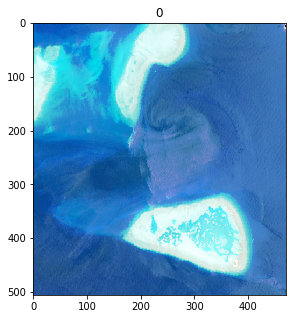

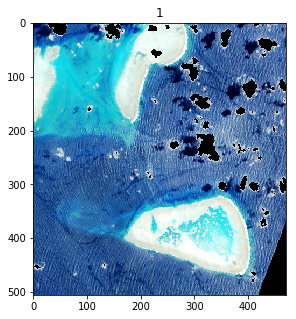

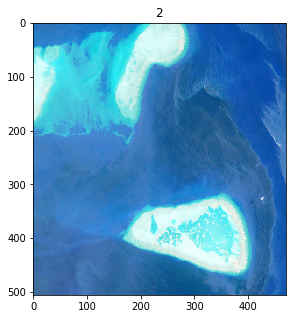

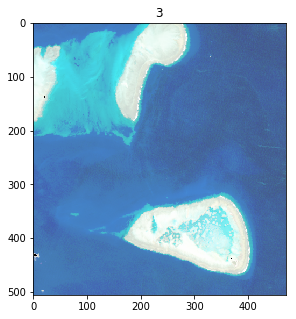

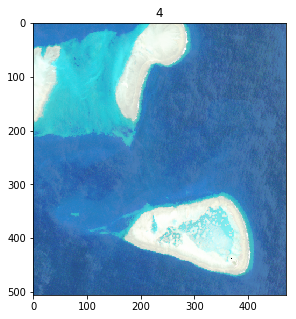

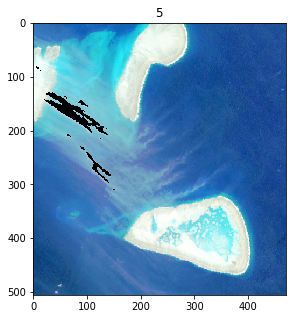

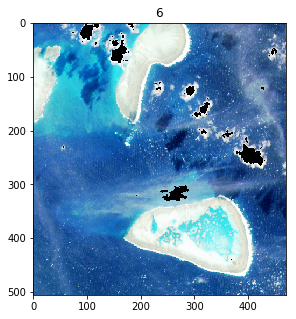

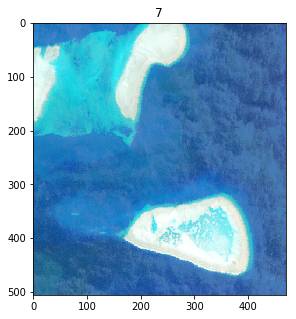

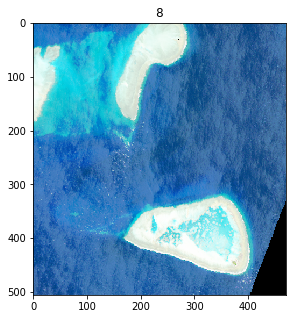

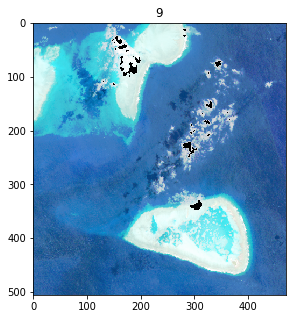

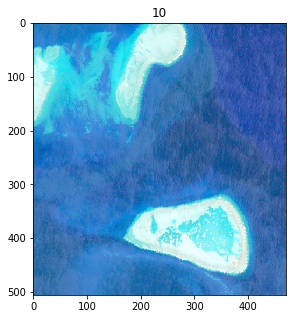

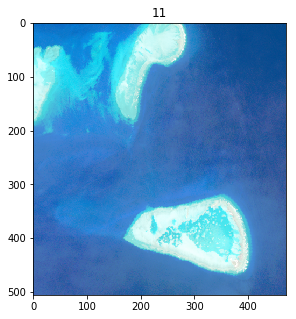

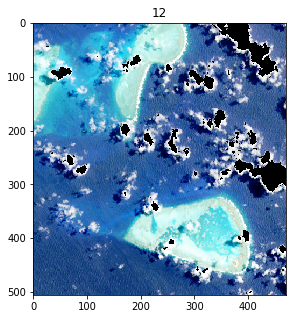

In [5]:
#Chad's script: print true-colour images for each time with good imagery...


#for each time slice of the dataset, extract the corresponding 
#dataset - just select red, green, and blue bands
data = []
n = len(list(data_mostly_cloud_free['time']))
for i in range(0,n):
    x = data_mostly_cloud_free.isel(['red','green','blue'], time = i)
    data.append(x)

#extract the time values from the geomedian dataset and then
#clean up values so they show just the date and not the time
imageNo=list(np.arange(n-1))
# time = list(test['time'].values)
# time_str = []
# for i in time:
#     x = str(i)[:10]
#     time_str.append(x)

#zip both the time and dataarrays together as a dictionary 
test_dict = dict(zip(imageNo,data))

#function for turning the datasets into numpy rgb arrays
from skimage import exposure
def makeTrueColour(ds):
    # find the shape of the data
    y, x,  = ds['red'].shape
    # make an empty array of the correct size, 3 dimensions (for red, green, blue), and of a decimal (floating point) number
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    # for each of red, green, blue, access the xarray, pull out the data for the time slice desired, and save it to the new array
    for i, colour in enumerate(['red','green','blue']):
        rawimg[:,:,i] = ds[colour].values
    # default DEA values for blank pixels are -999, change this to NaN (not a number, null in python)
    rawimg[rawimg == -999] = np.nan
    # stretch the colour range of the RGB data to it looks bright and vibrant to the human eye
    rawimg = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return rawimg 

#loop over the gemedian dictionary and create an rgb image for each time slice
rgb_images = {key: makeTrueColour(test_dict[key]) for key in test_dict}

#loop through the rgb_images dictionary and export out a plot as a .png
# CAUTION: this loop also plots the figures below so chews up memory
for key in rgb_images:
    fig = plt.figure(figsize=[5,5])
    # draw the scene
    imshow(rgb_images[key])
    # get the axis object resulting from the drawing
    ax = plt.gca()
    # add a title to the axes object, in this case, the time of the satellite pass
    ax.set_title(key) 

## Select which image to apply glint correction to

In [6]:
# Enter the number in the heading for the image that you are interested in

image = 5

## Select deep-sea area within image to base glint correction on

### Create image to draw polyon on

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

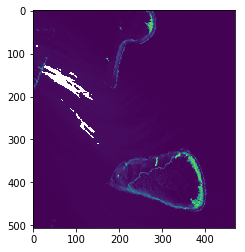

In [26]:
# Code from Ness

from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

import plotly.plotly as py
from traitlets import link
import ipywidgets as widgets
from datacube.utils import geometry

center = [(lat_min + ((lat_max - lat_min)/2)), (lon_min + ((lon_max - lon_min)/2))]
zoom = 12

m = Map(projection='aea', center=center, zoom=zoom,layout=dict(width='400px', height='400px'),basemap=basemaps.Esri.WorldImagery)

# Now create the DrawControls and add it to the Maps using add_control. 
# (there are the actions). The geo_json argument is the serialized geometry of the drawn path, 
# along with its embedded style.

draw_control = DrawControl(polyline={})

#add draw controls to maps
m.add_control(draw_control)
display(m)

# Show landsat imagery as well to ensure both images cover the same area. It the areas are not the same, use the widgets
# to scale the map...
imshow(nir.isel(time=image))


### Create a polygon from the shape drawn above, and save it in the same crs as the datacube data

In [9]:
# Code from Ness

from shapely.geometry import mapping, Polygon
from shapely.wkt import loads
import fiona
from osgeo import ogr
from osgeo import osr
from datacube.utils import geometry

geom_crs = geometry.CRS('EPSG:4326')
drawn_geom=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)
source = osr.SpatialReference()
source.ImportFromEPSG(4326)

target = osr.SpatialReference()
target.ImportFromEPSG(3577)

transform = osr.CoordinateTransformation(source, target)

poly = ogr.CreateGeometryFromWkt(drawn_geom.wkt)
poly.Transform(transform)

shapely_poly = loads(poly.ExportToWkt())

schema = {
   'geometry': 'Polygon',
   'properties': {'id': 'int',
                   'name': 'str'},
}

output_shpfile = '/g/data/u46/users/ah3144/dea-notebooks/Glint/deep_water_area.shp'
try:
   with fiona.open(output_shpfile, 'w', 'ESRI Shapefile', schema, crs = {'init': 'epsg:3577', 'no_defs': True}) as c:  
       c.write({
             'geometry': mapping(shapely_poly),
             'properties': {'id': 1,
                            'name': 'drawn_polygon'},
         })
except:
   print(c.closed)
   raise
c.closed

True

### Rasterise the shapefile and plot the area within the polygon drawn above

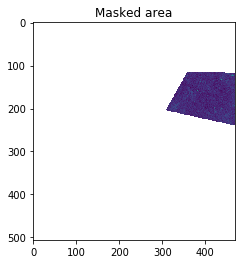

In [10]:
#Code from Chad and Robbi

#find the 'wkt' for GDA94 Albers Equal Area
import osr
import gdal
srs = osr.SpatialReference()
srs.ImportFromEPSG(3577)
prj_wkt = srs.ExportToWkt()

#find the width and height of the xarray dataset we want to mask
width,height = nir.isel(time=image).shape

#location of the shapefile we're converting
# project_area_CEA_albers_loc = data + project_ID + '_cea_albers.shp'

#create 'transform' tuple that will define the dimensions of the rasterized shapefile
easting = float(nir.x[0])
W_E_pixelRes = float(nir.y[0] - nir.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(nir.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(nir.x[0] - nir.x[1])
transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

def rasterize_vector(input_data, cols, rows, geo_transform,
                     projection, field=None, raster_path=None):
    """
    Rasterize a vector file and return an array with values for cells that occur within the shapefile. 
    This function is loaded as a module but for some wierd reason isn't working: 'module uncallable'
    """

    # If input data is a string, import as shapefile layer
    if isinstance(input_data, str):
        # Open vector with gdal
        data_source = gdal.OpenEx(input_data, gdal.OF_VECTOR)
        input_data = data_source.GetLayer(0)
    # If raster path supplied, save rasterized file as a geotiff
    if raster_path:
        # Set up output raster
        print('Exporting raster to {}'.format(raster_path))
        driver = gdal.GetDriverByName('GTiff')
        target_ds = driver.Create(raster_path, cols, rows, 1, gdal.GDT_UInt16)
    else:
        # If no raster path, create raster as memory object
        driver = gdal.GetDriverByName('MEM')  # In memory dataset
        target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    # Set geotransform and projection
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    # Rasterize shapefile and extract array using field if supplied; else produce binary array
    if field:
        gdal.RasterizeLayer(target_ds, [1], input_data, options=["ATTRIBUTE=" + field])
    else:
        gdal.RasterizeLayer(target_ds, [1], input_data)       
    band = target_ds.GetRasterBand(1)
    out_array = band.ReadAsArray()
    target_ds = None
    return out_array

# Rasterize vector
raster_deep_water_area = rasterize_vector("/g/data/u46/users/ah3144/dea-notebooks/Glint/deep_water_area.shp", height, width, transform,
                     prj_wkt, raster_path=None)

# Plot the 
plt.figure()
plt.title('Masked area')
imshow(red.isel(time=image).where(raster_deep_water_area > 0))

## OR:  Subplot method

### Grid the image and select which portions are 100% deep ocean

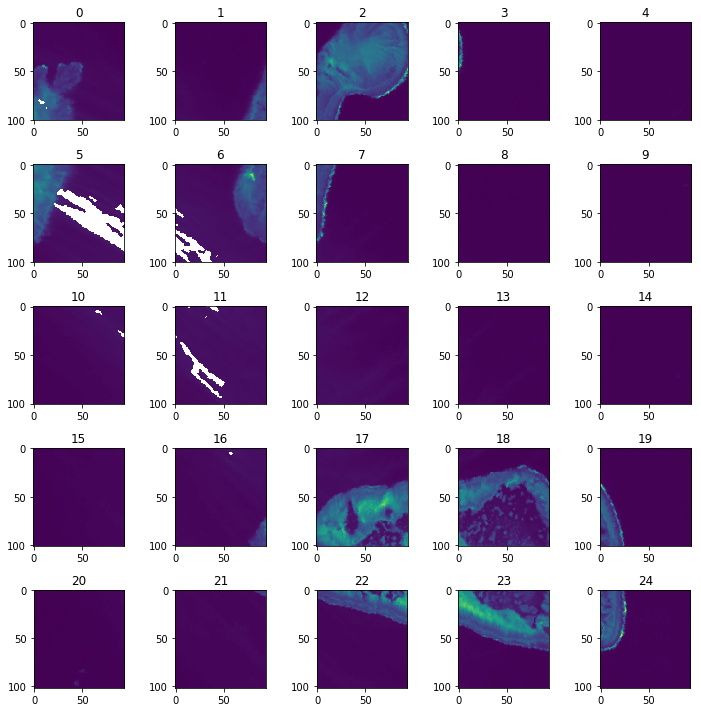

In [7]:
# Written with lots of help from Imam!

pixels_in_x = red.shape[2]
pixels_in_y = red.shape[1]

def break_up_plot(array,a,b):
    """function for doing an imshow thngy
    a = minimun x value for subplot, b = minimum y value for subplot """
    imshow(array.isel(x=slice((int (a*pixels_in_x)),(int ((a + 0.2)*pixels_in_x))),
                                y=slice(int (b*pixels_in_y),(int ((b + 0.2)*pixels_in_y))), time=image) , 
       vmin=np.min(array.isel(time=image)), vmax=np.max(array.isel(time=image)))

plt.figure(figsize = (10,10))
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, i * 5 + j + 1)
        plt.title(i * 5 + j)
        break_up_plot(red, j * 0.2, i * 0.2)
plt.tight_layout()

### Enter the title number for all images that are 100% deep ocean in the ?list below

In [8]:
deep_ocean_subplots = [9, 13, 14, 15, 12]

In [9]:
#########################################################################
# Identity selected subplots by their position in the the overall image
#########################################################################

# Create a function to round numbers down to the nearest multiple of five
def round_down(num):
    return num - (num%5)

# Calculate the position of a subplot within the area of interest based on it's title
def select_subplot(data):
    i = float (("%.1f" % ((data - round_down(data))/5)))
    j = round_down(data) / 25
    ij=[i,j]
    return ij

# Create a function that returns the position of each listed subplot within the area of interest
subplot_locations = []
for i in deep_ocean_subplots:
    x = select_subplot(i)
    subplot_locations.append(x)


#########################
#
##########################

# Define a function that creates a 1D (stacked) array of reflectance data for one band in one subplot
def deep_ocean_data(array,a):
    """function for doing an thing
    a = minimun x value for subplot, b = minimum y value for subplot """
    return ((array.isel(x=slice((int (a[0]*pixels_in_x)),(int ((a[0] + 0.2)*pixels_in_x))),
                                y=slice(int (a[1]*pixels_in_y),(int ((a[1] + 0.2)*pixels_in_y))), time=image)))

# List the bands of interest (these are the arrays containing the data)
bands = [nir, red, green, blue]

# Loop through the deep_ocean_data function for each specified subplot and create a list of arrays with data for 
# each band in each subplot
all_deep_ocean_data = []
for i in bands:
    for j in subplot_locations:
        x = deep_ocean_data(i,j)
        all_deep_ocean_data.append(x)


# Create lists to indicate which data arrays within the dataset correspond to which band
colours_x_images = len (deep_ocean_subplots) *4

nir_list = list(range(1,int(colours_x_images/4+1)))
red_list = list(range(int(colours_x_images/4+1),int(colours_x_images*2/4+1)))
green_list = list(range(int(colours_x_images*2/4+1), int(colours_x_images*3/4+1)))
blue_list = list(range(int(colours_x_images*3/4+1), int(colours_x_images*4/4+1)))


#Create a function to reduce data in lists within lists to a single list
def reduce_list_to_one_d(a):
    two_d = list(itertools.chain.from_iterable(a))
    return (list(itertools.chain.from_iterable(two_d)))

#Create a function to join all data from all_deep_ocean_data for the same band into a single list
def final_list(a):
    joined = []
    for i in a:
        x = reduce_list_to_one_d(np.asarray(all_deep_ocean_data[i-1:i]))
        joined.append(x)
    only_deep = list(itertools.chain.from_iterable(joined))
    return (only_deep)

## Identify glint

### Comment out the set of equations for the deep sea selection process that you didn't use

In [10]:
#################
# Polygon method
#################

# # Define x and y for plotting as 1D arrays - WHERE ALL DEEP OCEAN
# nir_masked_stacked = np.hstack(nir.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))
# red_masked_stacked = np.hstack(red.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))
# blue_masked_stacked = np.hstack(blue.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))
# green_masked_stacked = np.hstack(green.isel(time=image).where(raster_deep_water_area > 0).fillna(-999))

# nir_deep = np.extract((nir_masked_stacked >= 0), nir_masked_stacked)
# red_deep = np.extract((red_masked_stacked >= 0), red_masked_stacked)
# blue_deep = np.extract((blue_masked_stacked >= 0), blue_masked_stacked)
# green_deep = np.extract((green_masked_stacked >= 0), green_masked_stacked)

#################
# Subplot method
#################

# From subplot method
nir_deep = np.asarray(final_list(nir_list))
red_deep = np.asarray(final_list(red_list))
blue_deep = np.asarray(final_list(blue_list))
green_deep = np.asarray(final_list(green_list))

### Plot r,b, or g against nir and calculate a linear best fit line

### Calculate and plot the degree of glint for each pixel

red gradient:    1.116125534321218
red y-intercept: 18.330520893517644
blue gradient:    1.5374518523080332
blue y-intercept: 226.5770024491054
green gradient:    1.3948402440503453
green y-intercept: 84.21776652387442


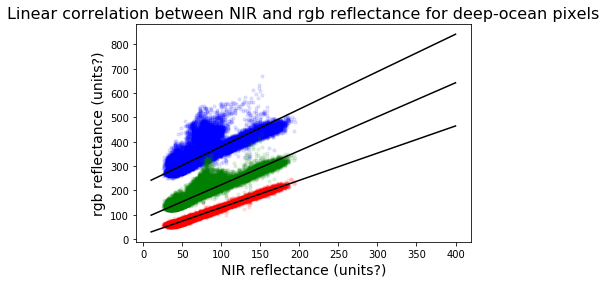

In [11]:
# Define x and y for plotting as 1D arrays
x = nir_deep
y1 = red_deep
y2 = blue_deep
y3 = green_deep

# Calculate linear best fit line
red_model = LinearRegression()
blue_model = LinearRegression()
green_model = LinearRegression()

red_model.fit(x[:, np.newaxis], y1)
blue_model.fit(x[:, np.newaxis], y2)
green_model.fit(x[:, np.newaxis], y3)

# Define x and y values for the best fit line
xfit = np.linspace(10,400)
y1fit = red_model.predict(xfit[:, np.newaxis])
y2fit = blue_model.predict(xfit[:, np.newaxis])
y3fit = green_model.predict(xfit[:, np.newaxis])

# Plot the data and the best fit line
plt.title('Linear correlation between NIR and rgb reflectance for deep-ocean pixels', fontsize = 16)
plt.xlabel('NIR reflectance (units?)', fontsize = 14)
plt.ylabel('rgb reflectance (units?)', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.scatter(x, y1, s = 10, color = 'red', alpha = 0.1)
plt.plot(xfit, y1fit, color = 'black')

plt.scatter(x, y2, s = 10, color = 'blue', alpha = 0.1)
plt.plot(xfit, y2fit, color = 'black')

plt.scatter(x, y3, s = 10, color = 'green', alpha = 0.1)
plt.plot(xfit, y3fit, color = 'black')

# Print gradient and y-intercept
print("red gradient:   ", red_model.coef_[0])
print("red y-intercept:", red_model.intercept_)

print("blue gradient:   ", blue_model.coef_[0])
print("blue y-intercept:", blue_model.intercept_)

print("green gradient:   ", green_model.coef_[0])
print("green y-intercept:", green_model.intercept_)

## Calculate and plot the degree of glint for each pixel and apply a glint correction to r,g,b data

In [12]:
# Proxy for glint: degree_of_glint = absolute length of line parallel to slope of best fit line (above). 
# This is found using trig - first term is distance between pixel value and min(nir) along x-axis,
# second term is the cosine of the angle between horizontal and best fit line

degree_of_glint = ((nir.isel(time=image))-(nir_deep.min()))/np.cos(np.deg2rad(np.rad2deg(np.arctan(red_model.coef_[0]))))


# Correct for glint in r,g,b using Hedley method. 

# Apply the Hedley correction to the cloud free data for the r,g,b data
red_corr = red.isel(time=image)-((red_model.coef_[0])*((nir.isel(time=image))-(nir_deep.min())))
blue_corr = blue.isel(time=image)-((blue_model.coef_[0])*((nir.isel(time=image))-(nir_deep.min())))
green_corr = green.isel(time=image)-((green_model.coef_[0])*((nir.isel(time=image))-(nir_deep.min())))

# Create nir_corr - an array of the same shape as red_corr (etc.) where all values equal nir_deep.min()
nir_corr = red_corr/red_corr*nir_deep.min()

## Plot wavelength v intensity (for max and min nir intensities in area)

Text(0,0.5,'Reflectance (units?)')

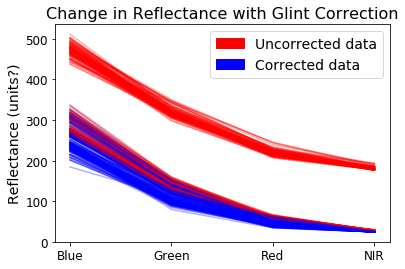

In [13]:
# Take the uncorrected data, and sepeartely the corrected data, and create an array for each, where each band and degree of 
# glint values are stacked into 1D arrays and then transposed to create a 2D array. 

############################
# Uncorrected deep-sea data:
############################
all_uncorr = np.transpose(np.vstack((blue_deep, green_deep, red_deep, nir_deep, nir_deep)))

##########################
# Corrected deep-sea data:
##########################

# Define a function that creates a 1D (stacked) array of reflectance data for one band in one subplot (this function is 
# the same as deep_ocean_data, except we do not need to specify time=image)
def deep_ocean_data_corr(array,a):
    """function for doing an thing
    a = minimun x value for subplot, b = minimum y value for subplot """
    return ((array.isel(x=slice((int (a[0]*pixels_in_x)),(int ((a[0] + 0.2)*pixels_in_x))),
                                y=slice(int (a[1]*pixels_in_y),(int ((a[1] + 0.2)*pixels_in_y))))))

# List the bands of interest (these are the arrays containing the data)
bands_corr = [nir_corr, red_corr, green_corr, blue_corr]

# Loop through the deep_ocean_data function for each specified subplot and create a list of arrays with data for 
# each band in each subplot
all_corr_deep_ocean_data = []
for i in bands_corr:
    for j in subplot_locations:
        x = deep_ocean_data_corr(i,j)
        all_corr_deep_ocean_data.append(x)

#Create a function to join all data from all_deep_ocean_data for the same band into a single list
def final_corr_list(a):
    joined = []
    for i in a:
        x = reduce_list_to_one_d(np.asarray(all_corr_deep_ocean_data[i-1:i]))
        joined.append(x)
    only_deep = list(itertools.chain.from_iterable(joined))
    return (only_deep)

# Generate lists for all corrected data for the deep-sea areas only
nir_corr_deep = np.asarray(final_corr_list(nir_list))
red_corr_deep = np.asarray(final_corr_list(red_list))
blue_corr_deep = np.asarray(final_corr_list(blue_list))
green_corr_deep = np.asarray(final_corr_list(green_list))

# Create a dataset of the corrected deep-sea data
all_corr = np.transpose(np.vstack((blue_corr_deep, green_corr_deep, red_corr_deep, nir_corr_deep, nir_deep)))
all_corr

###############################
# Manipulate data for plotting
###############################

# Order the rows of the two matricies from min-max degree_of_glint
all_uncorr_ordered = all_uncorr[all_uncorr[:,4].argsort()]
all_corr_ordered = all_corr[all_corr[:,4].argsort()]

# Check that the ordering has worked by finding the max nir value in all_corr and seeing what thr rgb values are for 
# that pixel
all_corr[np.where(all_corr[:,4] == all_corr[:,4].max())]

# Take only to values for the pixels with the lowest 100 and the highest 100 nir_deep values for all_uncorr and all_corr
minmax_uncorr = np.vstack(((all_uncorr_ordered[:100,:4]),(all_uncorr_ordered[-100:,:4])))
minmax_corr = np.vstack(((all_corr_ordered[:100,:4]),(all_corr_ordered[-100:,:4])))

###################################################################################
# Plot the highest and lowest uncorrected data (red) and the corrected data (blue)
###################################################################################

# Create a horizontal 1D array for the Landsat bands
x_axis = np.array([0,1,2,3])
labels = ['Blue','Green','Red','NIR']

# Loop through the pixels with the 100 highest and 100 lowest nir_deep values
plt.xticks(x_axis, labels, fontsize = 12)
plt.yticks(fontsize = 12)
for i in range (200):
    plt.plot(x_axis, (np.transpose(minmax_corr))[:,i], color = 'blue', alpha = 0.3)
    plt.plot(x_axis, (np.transpose(minmax_uncorr))[:,i], color = 'red', alpha = 0.3)
plt.title('Change in Reflectance with Glint Correction', fontsize = 16)
red_patch = mpatches.Patch(color='red', label='Uncorrected data')
blue_patch = mpatches.Patch(color='blue', label='Corrected data')
plt.legend(handles=[red_patch, blue_patch], fontsize = 14)
plt.ylabel('Reflectance (units?)', fontsize = 14)

## Load true-colour images to show glint removal

Bex's colour notebook
https://github.com/GeoscienceAustralia/dea-notebooks/blob/BexDunn/workflows/Retrieve_Landsat_plot_false_color_190218.ipynb

Other websites from Bex:
All about colour things in scikit... http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html
Loading colours in GDAL: https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
Random colour-related things:
https://stackoverflow.com/questions/42991524/how-to-optimize-this-image-iteration-in-numpy
https://www.programcreek.com/python/example/71304/cv2.COLOR_BGR2RGB

### Create datasets from data arrays

In [14]:
# # Create a dataset of rgb only_cloud_free.isel(time=image) data arrays
# red1 = xr.DataArray(red.isel(time=image), name = 'red_only_cloud_free')
# blue1 = xr.DataArray(blue.isel(time=image), name = 'blue_only_cloud_free')
# green1 = xr.DataArray(green.isel(time=image), name = 'green_only_cloud_free')
# nir1 = xr.DataArray(nir.isel(time=image), name = 'nir_only_cloud_free')
# dataset_only_cloud_free = xr.merge([red1, green1, blue1, nir1])

# Create a dataset of rgb only_cloud_free.isel(time=image) data arrays
red1 = xr.DataArray(red.isel(time=image), name = 'red')
blue1 = xr.DataArray(blue.isel(time=image), name = 'blue')
green1 = xr.DataArray(green.isel(time=image), name = 'green')
nir1 = xr.DataArray(nir.isel(time=image), name = 'nir')
dataset_only_cloud_free = xr.merge([red1, green1, blue1, nir1])


# Create a dataset of rgb corr data arrays
red_corr = xr.DataArray(red_corr, name = 'red_corr')
blue_corr = xr.DataArray(blue_corr, name = 'blue_corr')
green_corr = xr.DataArray(green_corr, name = 'green_corr')
nir_corr = xr.DataArray(nir_corr, name = 'nir_corr')
dataset_corr = xr.merge([red_corr, green_corr, blue_corr, nir_corr])

### Plot true-colour images with and without glint

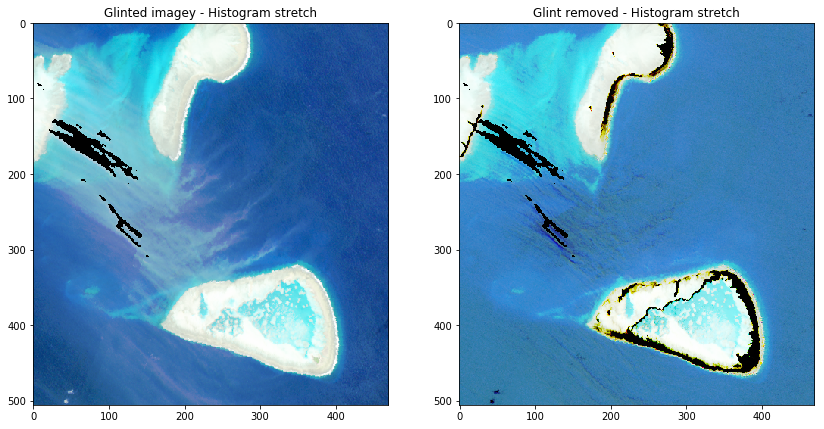

In [20]:
# HISTOGRAM STRETCH IMAGES
# Draw image with sun glint
def drawTrueColourHist(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red', 'green', 'blue']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow1 = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return img_toshow1


# Draw image with no sun glint
def drawTrueColourNoGlintHist(ds):
    '''this function takes the shape of an input band and uses swir1, nir and green to make and display a false
    color composite. Written by Mike Barnes, edited by Bex Dunn and Claire Krause'''
    y, x = ds['red_corr'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red_corr', 'green_corr', 'blue_corr']):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow2 = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    return img_toshow2



# Plot rgb glinted images and rgb images with glint removed, using a histogram stretch and by scaling intensities to maximum values
plt.figure(figsize = (14,14))
plt.subplot(121)
plt.title ('Glinted imagey - Histogram stretch')
imshow(drawTrueColourHist(dataset_only_cloud_free))
plt.subplot(122)
plt.title('Glint removed - Histogram stretch')
imshow(drawTrueColourNoGlintHist(dataset_corr))


## Export Geotiff

In [21]:
# Import neccesary code

import sys
import os
sys.path.append(os.path.abspath('/g/data/r78/cek156/dea-notebooks/algorithms'))
import DEAPlotting
import DEADataHandling

# Now just some regular module imports
from datacube import Datacube
from datetime import datetime

dc = Datacube(app = 'test')

ModuleNotFoundError: No module named 'DEAPlotting'

In [ ]:
# Plot a three-band image of the uncorrected data
DEAPlotting.three_band_image(dataset_only_cloud_free, ['red','green','blue'])

In [ ]:
# Plot a three-band image of the corrected data
DEAPlotting.three_band_image(dataset_corr, ['red_corr','green_corr','blue_corr'])

In [ ]:
# Export Geotiffs

# Uncorrected data
dataset_only_cloud_free.attrs['crs'] = data.crs
DEADataHandling.dataset_to_geotiff('uncorrected.tif', dataset_only_cloud_free)

# Corrected data
dataset_corr.attrs['crs'] = data.crs
DEADataHandling.dataset_to_geotiff('corrected.tif', dataset_corr)